In [11]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from typing import Union

In [12]:
import string
NUM_CHARS = 27
CHARS = list(string.ascii_lowercase)
CTOI = {c: i+1 for i, c in enumerate(CHARS)}
CTOI['.'] = 0
ITOC = {i: c for c, i in CTOI.items()}

In [ ]:
g = torch.Generator().manual_seed(2147483647)

In [13]:
class Dataset:

  def __init__(self, path: str, split: list = [0.8, 0.1, 0.1]) -> None:
    self.words = open(path, 'r').read().splitlines()
    self.train_set, test_eval = train_test_split(self.words, train_size=split[0])
    self.eval_set, self.test_set = train_test_split(test_eval, train_size=split[1])

data = Dataset('../../data/names.txt')
print(len(data.train_set))

25626


In [14]:
class NGramExplicitModel:

  def __init__(self, n: int, data: Dataset) -> None:
    self.n = n
    self.data = data

  def count(self):
    self.counts = torch.zeros(tuple([NUM_CHARS for _ in range(self.n)]), dtype=torch.int32)
    for word in self.data.train_set:
      context = [0] * (self.n-1)
      for c in word + '.':
        ix = CTOI[c]
        indices = tuple(context + [ix])
        self.counts[indices] += 1
        context = context[1:] + [ix]
      
    self.P = F.normalize((self.counts+1).float(), p=1, dim=-1)
  
  def sample(self, generator: torch.Generator, num_samples: int = 1):
    for i in range(num_samples):
      sample = []
      context = [0 for _ in range(self.n-1)]
      while True:
        ix = torch.multinomial(self.P[tuple(context)], num_samples=1, replacement=True, generator=generator).item()
        sample.append(ITOC[ix])
        if ix == 0:
          break
        context = context[1:] + [ix]

      print(''.join(sample))

  def eval(self, eval_set: Union[str, Dataset] = 'eval'):
    # average neg log likelihood
    llh, n = 0, 0
    if type(eval_set) is str:
      eval_set = self.data.eval_set if eval_set=='eval' else self.data.train_set if eval_set=='train' else self.data.test_set
    else:
      eval_set = eval_set.eval_set
    for word in eval_set:
      context = [0 for _ in range(self.n-1)]
      for c in word + '.':
        ix = CTOI[c]
        indices = tuple(context + [ix])
        logprob = torch.log(self.P[indices])
        llh += logprob
        n += 1
        context = context[1:] + [ix]
    return -llh/n

In [ ]:
class Linear(nn.Module):

  def __init__(self, n_in: int, n_out: int, bias: bool) -> None:
    super().__init__()
    self.W = torch.randn((n_in, n_out), generator=g) / (n_in)**0.5
    self.b = torch.randn(n_out, generator=g) if bias else None
  
  def forward(self, x):
    self.out = x @ self.W 
    if self.b is not None:
      self.out += self.b
    return self.out

  def parameters(self):
    return [self.W] + ([self.b] if self.b is not None else [])


class Tanh(nn.Module):

  def __init__(self) -> None:
    super().__init__()
  
  def forward(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []
  

class BatchNorm1d(nn.Module):

  def __init__(self, dim: int, eps: float = 1e-4, momentum: float = 0.1) -> None:
    super().__init__()
    self.training = True
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
    self.eps = eps
    self.gamma = 1
    self.beta = 0
    self.momentum = momentum

  def forward(self, x: torch.Tensor):
    if self.training:
      x_mean = x.mean(0, keepdim=True)
      x_var = x.var(0, keepdim=True)
    else:
      x_mean = self.running_mean
      x_var = self.running_var

    self.out = (x - x_mean) / (x_var**2 + self.eps)
    self.out = self.gamma * self.out + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * x_mean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * x_var
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]


class Embedding(nn.Module):

  def __init__(self, embed_dim: int, context_len: int) -> None:
    super().__init__()
    self.embed_dim = embed_dim
    self.context_len = context_len
    self.C = torch.randn((NUM_CHARS, embed_dim), generator=g)
  
  def forward(self, x):
    self.out = self.C[x]
    self.out = self.out.view(-1, (self.context_len)*self.embed_dim)
    return self.out
  
  def parameters(self):
    return [self.C]

In [15]:
class TwoLayerMLP(nn.Module):

  def __init__(self, context_len: int, embed_dim: int, hidden_layer_size: int, generator: torch.Generator = None) -> None:
    super().__init__()
    self.context_len = context_len
    self.embed_dim = embed_dim
    self.generator = generator
    self.C = torch.randn((NUM_CHARS, self.embed_dim), generator=self.generator)
    # C[xs].shape = (num_data_pairs, context_len, embed_dim)
    self.W1 = torch.randn((self.context_len*self.embed_dim, hidden_layer_size), generator=self.generator) / (self.context_len*self.embed_dim)**0.5
    self.b1 = torch.randn(hidden_layer_size, generator=self.generator)
    self.W2 = torch.randn((hidden_layer_size, NUM_CHARS), generator=self.generator)
    self.b2 = torch.randn(NUM_CHARS, generator=self.generator)
    self.params = [self.C, self.W1, self.b1, self.W2, self.b2]
    for p in self.params:
      p.requires_grad = True
  
  def forward(self, x):
    xenc = self.C[x]
    xenc = xenc.view(-1, (self.context_len)*self.embed_dim)
    h = torch.tanh(xenc @ self.W1 + self.b1)             # log counts -> only thing that will change in Transformers
    logits = h @ self.W2 + self.b2
    return logits

In [16]:
class NGramMLPModel:

  def __init__(self, n: int, data: Dataset, embed_dim: int, rc: float, hidden_layer_size: int = 100, generator: torch.Generator = None) -> None:
    self.n = n
    self.data = data
    self.rc = rc          # regularization coefficient
    self.xs, self.ys = self.prepare_ds()
    self.net = TwoLayerMLP(self.n-1, embed_dim, hidden_layer_size, generator)

  def prepare_ds(self, prepare_set: Union[str, Dataset] = 'train'):
    if type(prepare_set) is str:
      prepare_set = self.data.eval_set if prepare_set=='eval' else self.data.train_set if prepare_set=='train' else self.data.test_set
    else: 
      prepare_set = prepare_set.train_set
    # Create train set
    xs, ys = [], []
    for w in prepare_set:
      context = [0] * (self.n-1) 
      for c in w + '.':
        ix = CTOI[c]
        xs.append(context)
        ys.append(CTOI[c])
        context = context[1:] + [ix]
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

  def compute_loss(self, logits, y):
    return F.cross_entropy(logits, y) + self.rc*(self.net.W1**2).mean() + self.rc*(self.net.W2**2).mean()


  def train_network(self, num_iters: int, lr: float, batch_size: int, generator: torch.Generator):
    losses = []
    for k in range(num_iters):
      # minibatch construct
      ix = torch.randint(0, self.xs.shape[0], (batch_size,), generator=generator)
      Xb, Yb = self.xs[ix], self.ys[ix] # batch X,Y

      # NN forward pass
      logits = self.net(self.xs)

      # loss: negative llh of probs corresponding to true labels
      loss = self.compute_loss(logits, self.ys)
      
      ## NN backward pass
      for p in self.net.params:
        p.grad = None       # set grad to 0
      loss.backward()
      if k%10 == 0:
        print(f'Iter {k}, loss {loss.item()}')
      losses.append(loss.item())
      for p in self.net.params:
        p.data += -lr*p.grad
    
    # plot losses
    plt.plot(range(len(losses)), losses)
    plt.ylim(bottom=0)
    plt.xlabel('Training epoch'); plt.ylabel('Loss')
    plt.show()


  def sample(self, generator: torch.Generator, num_samples: int):
    for i in range(num_samples):
      sample = []
      context = [0 for _ in range(self.n-1)]
      while True:
        logits = self.net(torch.tensor(context))
        counts = logits.exp()
        p = F.normalize(counts.float(), p=1, dim=-1)

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=generator).item()
        sample.append(ITOC[ix])
        if ix == 0:
          break
        context = context[1:] + [ix]

      print(''.join(sample))

  def eval(self, eval_set: Union[str, Dataset] = 'eval'):
    # average neg log likelihood
    xs, ys = self.prepare_ds(eval_set)
    logits = self.net(xs)
    loss = self.compute_loss(logits, ys)   
    return loss.item()
  

In [17]:
g = torch.Generator().manual_seed(2147483647)
data = Dataset('../../data/names.txt')

In [18]:
model = NGramExplicitModel(n=2, data=data)
model.count()
model.eval('eval')

tensor(2.4565)

Iter 0, loss 16.549583435058594
Iter 10, loss 8.056435585021973
Iter 20, loss 5.181474685668945
Iter 30, loss 3.5091047286987305
Iter 40, loss 3.1949329376220703
Iter 50, loss 3.6456778049468994
Iter 60, loss 4.544256687164307
Iter 70, loss 4.1709885597229
Iter 80, loss 2.9693915843963623
Iter 90, loss 3.28916072845459


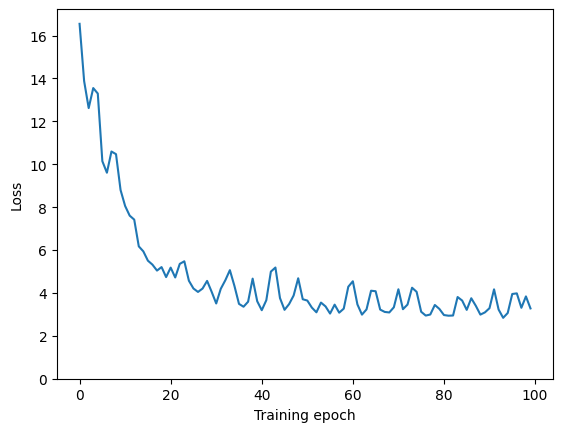

Iter 0, loss 3.160080671310425
Iter 10, loss 2.599710702896118
Iter 20, loss 2.564485549926758
Iter 30, loss 2.5563724040985107
Iter 40, loss 2.553121328353882
Iter 50, loss 2.5512068271636963
Iter 60, loss 2.5497913360595703
Iter 70, loss 2.5486133098602295
Iter 80, loss 2.547569513320923
Iter 90, loss 2.546609878540039
Iter 100, loss 2.5457074642181396
Iter 110, loss 2.544847011566162


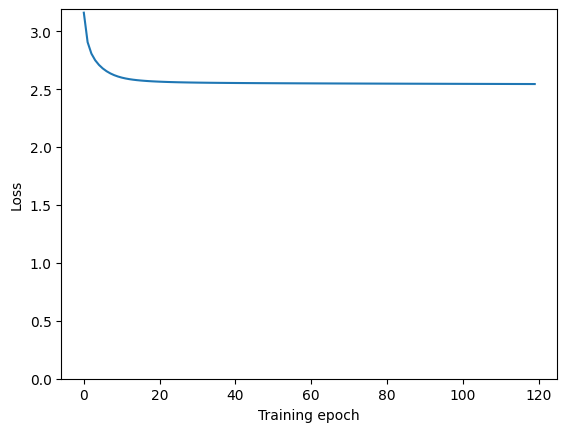

In [19]:
%matplotlib inline
g = torch.Generator().manual_seed(2147483647)
for rc in [0.01]:
  model = NGramMLPModel(2, data, 20, rc, 100, g)
  model.train_network(100, 1.0, 32, g)
  model.train_network(120, 0.1, 32, g)
  loss = model.eval('eval')

In [20]:
g = torch.Generator().manual_seed(2147483647)
model.sample(generator=g, num_samples=5)

mor.
aws.
minaylusykas.
knaniaisah.
anchthizarie.
